In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
mlflow.set_experiment("Logistic_Regression_Experiment")

2025/08/10 19:16:12 INFO mlflow.tracking.fluent: Experiment with name 'Logistic_Regression_Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/dell/Desktop/projects/thyroid_cancer/ml_notebooks/mlruns/470317910536550213', creation_time=1754833572895, experiment_id='470317910536550213', last_update_time=1754833572895, lifecycle_stage='active', name='Logistic_Regression_Experiment', tags={}>

#### 1. Load dataset


In [2]:
df = pd.read_csv('dataset.csv')  # Replace with your actual filename

# Target column
target = 'Recurred'

#### 2. Split Data

In [3]:
X = df.drop(columns=[target])
y = df[target]
y = df[target].map({'No': 0, 'Yes': 1})

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 * 0.9 = 0.225 of original data
    stratify=y_temp,
    random_state=42
)


#### 3. Preprocessing


In [4]:
# Define numerical and categorical columns
numerical_cols = ['Age'] if 'Age' in X.columns else []
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

#### 4. Build pipeline


In [5]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
])



#### 5. Grid search

In [6]:
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall',  # or 'roc_auc' if preferred
    cv=5,
    n_jobs=-1,
    verbose=1
)

#### 5. Fit the model

In [7]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l1', 'l2']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


##### Train Results

In [8]:
best_model = grid_search.best_estimator_
ytrain_pred = best_model.predict(X_train)
ytrain_prob = best_model.predict_proba(X_train)[:, 1]

print("Best Params:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_train, ytrain_pred))
print("ROC-AUC Score:", roc_auc_score(y_train, ytrain_prob))

Best Params: {'classifier__C': 10, 'classifier__penalty': 'l2'}

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       185
           1       0.96      0.92      0.94        73

    accuracy                           0.97       258
   macro avg       0.96      0.95      0.96       258
weighted avg       0.96      0.97      0.96       258

ROC-AUC Score: 0.9954831543872639


#### 7. Evaluate model

In [9]:
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:, 1]

print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98        62
           1       0.96      0.92      0.94        24

    accuracy                           0.97        86
   macro avg       0.96      0.95      0.96        86
weighted avg       0.96      0.97      0.96        86

ROC-AUC Score: 0.9798387096774193


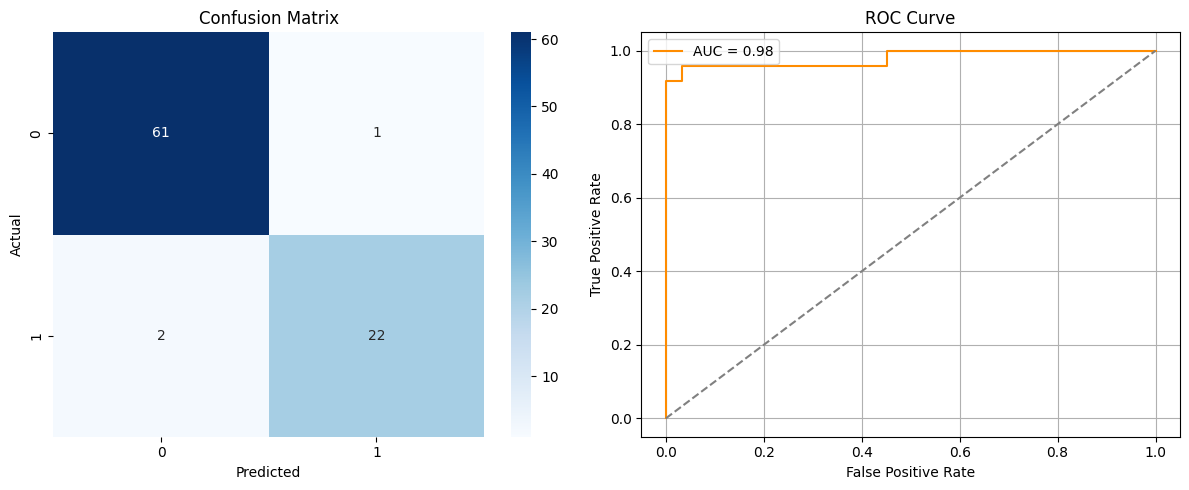

In [10]:
# Compute confusion matrix and ROC values
cm = confusion_matrix(y_val, y_pred)
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
auc = roc_auc_score(y_val, y_prob)

# Create a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# 2️⃣ ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)

# Final layout
plt.tight_layout()
plt.show()


#### Save model and generate report

In [12]:
import joblib

joblib_file = "../artifacts/model.joblib"
joblib.dump(best_model, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to ../artifacts/model.joblib


In [17]:
import pandas as pd
import plotly.express as px

# Assuming you already have `best_model` after GridSearchCV

# 1. Extract preprocessor and classifier from pipeline
preprocessor = best_model.named_steps['preprocessor']
classifier = best_model.named_steps['classifier']

# 2. Get feature names after preprocessing
feature_names = []

# This assumes preprocessor is a ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if name != 'remainder':
        # If transformer has get_feature_names_out (e.g., OneHotEncoder)
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            # fallback: just use original column names
            transformed_names = columns
        feature_names.extend(transformed_names)
    else:
        # passthrough columns if any
        feature_names.extend(columns)

# 3. Extract coefficients from logistic regression
coefficients = classifier.coef_[0]

# 4. Build DataFrame for features and coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 5. Add absolute coefficient for sorting and sort ascending for horizontal bar chart
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=True)

# 6. Create Plotly horizontal bar chart
fig = px.bar(
    coef_df,
    x='Coefficient',
    y='Feature',
    orientation='h',
    color=coef_df['Coefficient'] > 0,
    color_discrete_map={True: 'green', False: 'red'},
    title='Feature Importance (Logistic Regression Coefficients)',
    labels={'Coefficient': 'Coefficient Value', 'Feature': 'Feature'}
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})

# 7. Save interactive plot to HTML file
html_path = '../feature_importance.html'
fig.write_html(html_path)

print(f"Interactive feature importance saved as HTML at {html_path}")


Interactive feature importance saved as HTML at ../feature_importance.html


In [ ]:
ytest_prob = best_model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, best_model.predict(X_test))
recall = recall_score(y_test, best_model.predict(X_test))

print(f"F1 Score on Test Set: {f1:.4f}")
print(f"Recall on Test Set: {recall:.4f}")

F1 Score on Test Set: 0.9565
Recall on Test Set: 1.0000


#### 8. MLflow tracking


In [ ]:
from mlflow.models.signature import infer_signature

input_example = X_test.iloc[:5]
signature = infer_signature(X_test, best_model.predict(X_test))

# Log to MLflow
with mlflow.start_run():
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, ytest_prob))
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("recall", recall)
    mlflow.sklearn.log_model(
        best_model,
        name="logistic_model",
        input_example=input_example,
        signature=signature
    )


c:\Users\dell\Desktop\projects\thyroid_cancer\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
